In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score as ros
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
import lightgbm as lgbm
from sklearn.ensemble import StackingClassifier
       
%load_ext skip_kernel_extension_py

## Import and Preprocess Data

In a previous notebook, we found that most columns and rows contained NaNs. In order to fill these, we first normalized all non-NaN values in both the testing and training datasets. We then used Sklearn's IterativeImputer class with a BayesianRidge estimator, which was fit on the normalized training set, to impute the NaNs in both the training and testing datasets. Given that this was a computationally heavy task that took over an hour, we saved the resulting datasets, which we will use in this notebook to develop a suitable classification model. 

In [2]:
#Import previously normalized/imputed data.
test = pd.read_csv("../input/imputed-data-blended/imputed_test_blending.csv")
X = pd.read_csv("../input/imputed-data-blended/imputed_train_blending.csv")

In [3]:
#Import original data for target values.
y = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv", usecols=['claim'])

In [4]:
#Display samples of DataFrames.
for i in [X, test]:
    display(i.head())

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,nan_count
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.01770,1.0
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.28359,0.0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.40690,5.0
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.51486,2.0
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.23049,8.0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,nan_count
0,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357,1.0
1,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125,0.0
2,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797,1.0
3,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910,0.0
4,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796,0.0


In [5]:
#Dislpay Nulls.
print(f'\nRows with NaNs in training set: {X.isnull().any(axis=1).sum()}')
print(f'Columns with NaNs in training set: {X.isnull().any(axis=0).sum()}')
print(f'Rows in training set: {len(X)}')
print(f'\nRows with NaNs in testing set: {test.isnull().any(axis=1).sum()}')
print(f'Columns with NaNs in testing set: {test.isnull().any(axis=0).sum()}')
print(f'Rows in testing set: {len(test)}')


Rows with NaNs in training set: 0
Columns with NaNs in training set: 0
Rows in training set: 957919

Rows with NaNs in testing set: 0
Columns with NaNs in testing set: 0
Rows in testing set: 493474


In [6]:
#Examine distribution of target values.
display(y.value_counts())

claim
0        480404
1        477515
dtype: int64

From what we can see here, there is nearly an equal distribution of classes in the training dataset. As such, we don't have to perform upsample/downsampling or SMOTEing. 

<AxesSubplot:>

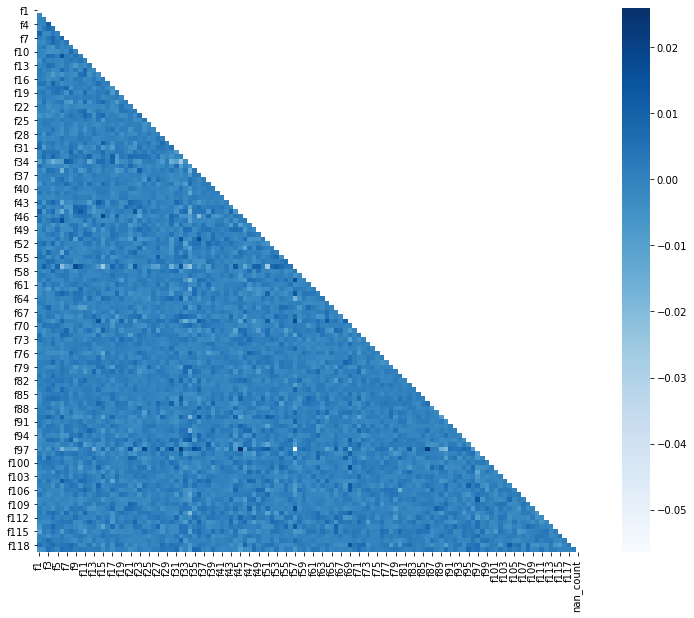

In [7]:
#Create correlation map.
corrmap = X.corr()
corr_mask = np.triu(corrmap)
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmap, square=True, mask=corr_mask, cmap="Blues")

We can see that there is no real correlation between any of the features, nor between any feature and the target. Since there is no real inter-feature correlation, we don't have any redundant information, which means we can use all features. This will likely prove more useful than specifically selecting features with the highest correlations with the target, since none of the features show any significant correlation in this regard. 

100%|██████████| 118/118 [15:01<00:00,  7.64s/it]


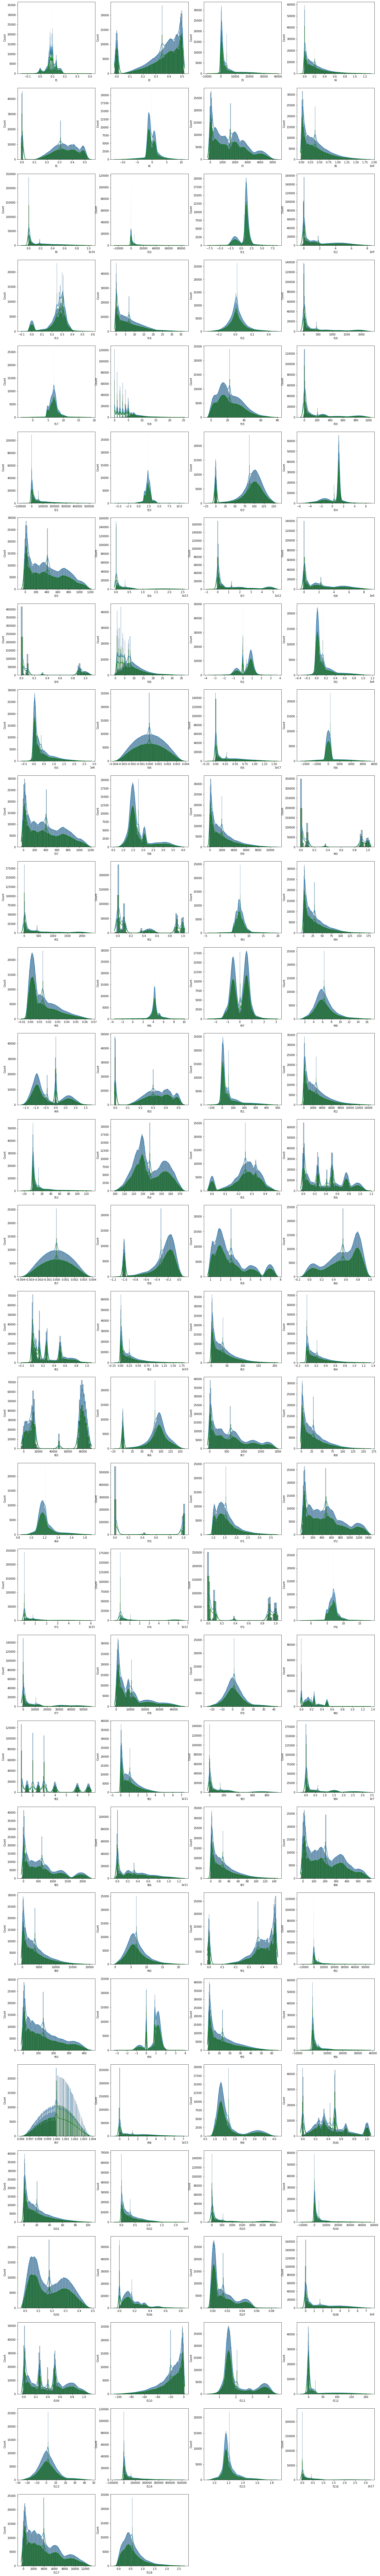

In [8]:
#Compare distributions for all features.
plt.figure(figsize=(24, 6*(118/4)))
for i in tqdm(range(len(X.columns.tolist()[:-1]))):
    plt.subplot(30, 4, i+1)
    sns.histplot(X[f'f{i+1}'], kde=True)
    sns.histplot(test[f'f{i+1}'], kde=True, color='green')
plt.show()

The distributions of values for all features appears to be quite similar for both training and testing datasets. As such, there does not appear to be any dataset shift. Additionally, we expect there to be a similar distribution of target values between the training and testing datasets.

In [9]:
#Split data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=5)

## Find Best Hyperparameters for Base Models

Note, in previous versions of this notebook we ran the following cells to determine the optimal hyperparameters for these base models. As can be seen, we ran 75 trials for each model using optuna, which took quite a while. Since we're previously identified the optimal hyperparameters, we will skip these cells using a customized cell-magic command. 

Credit for this custom cell-magic script is due to RobbeL https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all/43584169#43584169

As we are skipping the following cells, they won't output the AUC-ROC score identified with the optimal hyperparameters for each model. Nonethtless, we previously saved the scores, which are approximately as follows:

* Catboost: 0.8155
* LightGBM: 0.8154
* XGBoost: 0.8158

In [10]:
%%skip True

#Create helper function.
def tune_model(objective):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=75)
    best_params = study.best_params
    best_score = study.best_value
    print(f'Best roc-auc score: {best_score}')
    print(f'\nBest parameters: {best_params}')
    return best_params

In [11]:
%%skip True

%%time
#Define an objective function to be maximized for XGBClassifier.
def objective_xgb(trial):
    
    #Set up parameters and dtrain matrix.
    splits = 5
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=5)
    
    #Create array of zeros for storing out-of-fold predictions.
    oof_preds = np.zeros(X.shape[0])
    preds = 0
    model_feature_importance = 0
    mean_auc = 0
    
    #Define parameter space.
    param_space = {
        'max_depth': trial.suggest_int("max_depth", 1, 10, 1),
        'gamma': trial.suggest_float('gamma', 0,1),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0,50),
        'reg_lambda' : trial.suggest_float('reg_lambda', 10,100),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0,1),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0, .15),
        'tree_method':'gpu_hist', 
        'gpu_id': 0,
        'random_state': 5,
        'n_estimators' : 10000,
        'max_bin' : trial.suggest_int('max_bin', 200, 550, 1),
        'objective': 'binary:logistic',
        'use_label_encoder':False
    }
    
    #Generate folds, train model, and make predictions for each fold.
    for num, (train_indx, valid_indx) in tqdm(enumerate(kf.split(X, y))):
        X_train, X_valid = X.loc[train_indx], X.loc[valid_indx]
        y_train, y_valid = y.loc[train_indx], y.loc[valid_indx]
        
        model = xgb.XGBClassifier(**param_space)
        model.fit(X_train, y_train.values.ravel(),
                 verbose=False,
                 eval_set=[(X_valid, y_valid.values.ravel())],
                 eval_metric='auc',
                 early_stopping_rounds=300)
        
        model_feature_importance += model.feature_importances_ / splits
        
        #Obtain out of fold predictions from validation set.
        #This is used for hyperparameter optimization.
        oof_preds[valid_indx] = model.predict_proba(X_valid)[:, 1]
        
        #Obtain score for model fold.
        fold_auc = ros(y_valid, oof_preds[valid_indx])
        print(f'Fold {num} auc score: {fold_auc}')
        
        #Mean score for all folds.
        mean_auc += fold_auc / splits
        
    print(f"\nOverall ROC AUC: {mean_auc}")
    
    return mean_auc

#Run trials
xgb_optuna = tune_model(objective_xgb)

In [12]:
%%skip True

#Define an objective function to be maximized for CatBoostClassifier.
def objective_cat(trial):
    
    #Set up parameters and dtrain matrix.
    splits = 3
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=5)
    
    #Create array of zeros for storing out-of-fold predictions.
    oof_preds = np.zeros(X.shape[0])
    preds = 0
    model_feature_importance = 0
    mean_auc = 0
    
    #Define parameter space.
    param_space = {
        'max_depth': trial.suggest_int("max_depth", 1, 10, 1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 10,100),
        'learning_rate': trial.suggest_float('learning_rate', 0, .15),
        'n_estimators': 5000,
        'task_type':'GPU', 
        'devices': '0:1',
        'random_state': 5,
        'max_bin' : trial.suggest_int('max_bin', 200, 550, 1),
        'subsample' : trial.suggest_float('subsample', 0, 1),
        'eval_metric': 'AUC',
        'bootstrap_type':'Poisson'
    }
    
    #Generate folds, train model, and make predictions for each fold.
    for num, (train_indx, valid_indx) in tqdm(enumerate(kf.split(X, y))):
        X_train, X_valid = X.loc[train_indx], X.loc[valid_indx]
        y_train, y_valid = y.loc[train_indx], y.loc[valid_indx]
        
        eval_dataset = Pool(X_valid, y_valid)
        
        model = CatBoostClassifier(**param_space)
        model.fit(X_train, y_train,
                 verbose=False,
                 eval_set=eval_dataset,
                 early_stopping_rounds=300)
        
        model_feature_importance += model.feature_importances_ / splits
        
        #Obtain out of fold predictions from validation set.
        #This is used for hyperparameter optimization.
        oof_preds[valid_indx] = model.predict_proba(X_valid)[:, 1]
        
        #Obtain score for model fold.
        fold_auc = ros(y_valid, oof_preds[valid_indx])
        print(f'Fold {num} auc score: {fold_auc}')
        
        #Mean score for all folds.
        mean_auc += fold_auc / splits
        
    print(f"\nOverall ROC AUC: {mean_auc}")
    
    return mean_auc

#Run trials
cat_optuna = tune_model(objective_cat)

**LGBM Parameters**

In [13]:
%%skip True

#Define an objective function to be maximized for LBGMClassifier.
def objective_lbgm(trial):
    
    #Set up parameters and dtrain matrix.
    splits = 5
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=5)
    
    #Create array of zeros for storing out-of-fold predictions.
    oof_preds = np.zeros(X.shape[0])
    preds = 0
    model_feature_importance = 0
    mean_auc = 0
    
    #Define parameter space.
    lgbm_params = {
                     "objective": trial.suggest_categorical("objective", ['binary']),
                     "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt']),
                     "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                     "max_depth": trial.suggest_int("max_depth", 1, 16),
                     "learning_rate": trial.suggest_float("learning_rate", 0.1, 1, step=0.01),
                     "n_estimators": 15000,        
                     "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 100.0, step=0.1),
                     "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 100.0, step=0.1),
                     "random_state": 5,
                     "bagging_seed": trial.suggest_categorical("bagging_seed", [42]),
                     "feature_fraction_seed": trial.suggest_categorical("feature_fraction_seed", [42]),
                     "subsample": trial.suggest_float("subsample", 0.6, 1, step=0.01),
                     "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1, step=0.01),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    'min_child_weight': trial.suggest_categorical('min_child_weight', [256]),
                     'max_bin' : trial.suggest_int('max_bin', 50, 250)
}
    
    #Generate folds, train model, and make predictions for each fold.
    for num, (train_indx, valid_indx) in tqdm(enumerate(kf.split(X, y))):
        X_train, X_valid = X.loc[train_indx], X.loc[valid_indx]
        y_train, y_valid = y.loc[train_indx], y.loc[valid_indx]
        
        model = lgbm.LGBMClassifier(**lgbm_params)
        model.fit(X_train, y_train.values.ravel(),
                 verbose=False,
                 eval_set=[(X_valid, y_valid.values.ravel())],
                 eval_metric='auc',
                 early_stopping_rounds=150)
        
        model_feature_importance += model.feature_importances_ / splits
        
        #Obtain out of fold predictions from validation set.
        #This is used for hyperparameter optimization.
        oof_preds[valid_indx] = model.predict_proba(X_valid)[:, 1]
        
        #Obtain score for model fold.
        fold_auc = ros(y_valid, oof_preds[valid_indx])
        print(f'Fold {num} auc score: {fold_auc}')
        
        #Mean score for all folds.
        mean_auc += fold_auc / splits
        
    print(f"\nOverall ROC AUC: {mean_auc}")
    
    return mean_auc

#Run trials
lgbm_optuna = tune_model(objective_lbgm)

## Find Optimal Hyperparameters for Meta-Model

As with the base models, we used optuna to find the optimal hyperparameters for our meta-model. This was a very time-consuming process, as it involved cross-validation and obtaining predictions from multiple gradient-boosting models; as such, we ran the program using GPU and saved the optimal parameters. In order to save time, we will skip the optimization cell and simply use the previously-identified optimal hyperparameters for the meta-model in the next section.

The AUC-ROC score for the best-performing stacked model identified is: 0.8167. As can be seen, the stacked model performs better than each of the base models.

In [14]:
models = [('xgb1', xgb.XGBClassifier(max_depth=2,
                                     gamma=0.42128623263686943,
                                     reg_alpha=13.002596237041757,
                                     reg_lambda=21.341562971454067,
                                     colsample_bytree=0.2527228225382093,
                                     min_child_weight=2.2987723459855838,
                                     learning_rate=0.08687739423816797,
                                     max_bin=495,
                                     gpu_id=0,
                                     tree_method='gpu_hist',
                                     random_state=5,
                                     n_estimators=8000,
                                     use_label_encoder=False,
                                     objective='binary:logistic')),
          
          ('cat', CatBoostClassifier(max_depth=4,
                                     reg_lambda=24.520455674851036,
                                     learning_rate=0.02867314631306076,
                                     max_bin=505,
                                     subsample=0.8068183652307186,
                                     n_estimators=8000,
                                     task_type='GPU',
                                     devices='0:1',
                                     random_state=5,
                                     eval_metric='AUC',
                                     bootstrap_type='Poisson',
                                     verbose=False)),
          
          ('lbg', lgbm.LGBMClassifier(objective='binary',
                                      boosting_type='gbdt',
                                      num_leaves=6,
                                      max_depth=2,
                                      learning_rate=.1,
                                      n_estimators=7000,
                                      reg_alpha=25.0,
                                      reg_lambda=76.7,
                                      random_state=42,
                                      bagging_seed=42,
                                      feature_fraction_seed=42,
                                      n_jobs=-1,
                                      subsample=0.98,
                                      subsample_freq=1,
                                      colsample_bytree=0.69,
                                      min_child_samples=54,
                                      min_child_weight=256))]

In [15]:
%%skip True

#Define an objective function to be maximized for StackingClassifier.
def objective_meta(trial):
    
    meta_param_space = {
        'max_depth': trial.suggest_int("max_depth", 1, 10, 1),
        'gamma': trial.suggest_float('gamma', 0,1),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0,50),
        'reg_lambda' : trial.suggest_float('reg_lambda', 10,100),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0,1),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0, .15),
        'tree_method':'gpu_hist', 
        'gpu_id': 0,
        'random_state': 5,
        'n_estimators' : 8000,
        'max_bin' : trial.suggest_int('max_bin', 200, 550, 1),
        'objective': 'binary:logistic',
        'use_label_encoder':False}
    
    clf = StackingClassifier(estimators=models, 
                             final_estimator=xgb.XGBClassifier(**meta_param_space), 
                             cv=3)
    
    #Obtain predictions on X_valid.
    clf.fit(X_train, y_train.values.ravel())
    clf_pred = clf.predict_proba(X_valid)[:, 1]
    
    meta_auc = ros(y_valid, clf_pred)    
        
    print(f'Auc for this round: {meta_auc}')
    
    return meta_auc

meta_optuna = tune_model(objective_met2a)

## Stack Models and Obtain Prediction

Having obtained the optimal hyperparameters for all models, including our meta-model, we are now prepared to obtain predictions from our stacked model for the test dataset. In the following cell, we create an instance of StackingClassifier with a 5-fold cross validation. This classifier has two levels; level-0 is comprised of the base models, and level-1 is comprised of our meta-model. The meta-param-space variable contains the optimal hyperparameters identified for the meta-model. 

In [16]:
meta_param_space =  {'max_depth': 3, 
                     'gamma': 0.12970787138617168, 
                     'reg_alpha': 15.056592603960167, 
                     'reg_lambda': 76.8501171470906, 
                     'colsample_bytree': 0.6554985217430114, 
                     'min_child_weight': 3.654980551295688, 
                     'learning_rate': 0.06853956803108749, 
                     'max_bin': 206,
                     'tree_method':'gpu_hist', 
                     'gpu_id': 0,
                     'random_state': 5,
                     'n_estimators' : 8000,
                     'objective': 'binary:logistic',
                     'use_label_encoder':False}

#Create stacked model.
meta_model = StackingClassifier(estimators=models, 
                             final_estimator=xgb.XGBClassifier(**meta_param_space), 
                             cv=5)
#Fit stacked model.
meta_model.fit(X_train, y_train.values.ravel())

#Obtain predictions.
meta_pred_valid = meta_model.predict_proba(X_valid)[:, 1]
meta_pred_roc = ros(y_valid, meta_pred_valid)
print(f'AUC-ROC Score for validation set: {meta_pred_roc}')

meta_pred_test = meta_model.predict_proba(test)[:,1]

[13:50:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:15:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [17]:
meta_pred_test = pd.Series(meta_pred_test)
test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")

In [18]:
# Save the predictions to a CSV file
output = pd.DataFrame({'id': test['id'],
                       'claim': meta_pred_test})
output.to_csv('submission.csv', index=False)